In [108]:
import sys
import os
import wget

import numpy as np
import pandas as pd

from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import gaussian_kde

from empiricaldist import Pmf
from empiricaldist import Cdf

from fractions import Fraction
from matplotlib import pyplot as plt
from scipy.stats import binom
from scipy.interpolate import interp1d

from utils import decorate
from utils import set_pyplot_params
from utils import make_binomial
from utils import make_die
from utils import add_dist_seq

In [57]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [3]:
set_pyplot_params()

## Diachronic Bayes

There is another way to think of Bayes's theorem: it gives us a way to
update the probability of a hypothesis, $H$, given some body of data, $D$.

This interpretation is "diachronic", which means "related to change over time"; in this case, the probability of the hypotheses changes as we see new data.

Rewriting Bayes's theorem with $H$ and $D$ yields:

$$P(H|D) = \frac{P(H)~P(D|H)}{P(D)}$$

In this interpretation, each term has a name:

-  $P(H)$ is the probability of the hypothesis before we see the data, called the prior probability, or just **prior**.

-  $P(H|D)$ is the probability of the hypothesis after we see the data, called the **posterior**.

-  $P(D|H)$ is the probability of the data under the hypothesis, called the **likelihood**.

-  $P(D)$ is the **total probability of the data**, under any hypothesis.

In [30]:
def update(table):
    """Compute the posterior probabilities."""
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return prob_data

## The Monty Hall Problem

Next we'll use a Bayes table to solve one of the most contentious problems in probability.

The Monty Hall problem is based on a game show called *Let's Make a Deal*. If you are a contestant on the show, here's how the game works:

* The host, Monty Hall, shows you three closed doors -- numbered 1, 2, and 3 -- and tells you that there is a prize behind each door.

* One prize is valuable (traditionally a car), the other two are less valuable (traditionally goats).

* The object of the game is to guess which door has the car. If you guess right, you get to keep the car.

Suppose you pick Door 1. Before opening the door you chose, Monty opens Door 3 and reveals a goat. Then Monty offers you the option to stick with your original choice or switch to the remaining unopened door.

To maximize your chance of winning the car, should you stick with Door 1 or switch to Door 2?

To answer this question, we have to make some assumptions about the behavior of the host:

1.  Monty always opens a door and offers you the option to switch.

2.  He never opens the door you picked or the door with the car.

3.  If you choose the door with the car, he chooses one of the other
    doors at random.

Under these assumptions, you are better off switching. 
If you stick, you win $1/3$ of the time. If you switch, you win $2/3$ of the time.

If you have not encountered this problem before, you might find that
answer surprising. You would not be alone; many people have the strong
intuition that it doesn't matter if you stick or switch. There are two
doors left, they reason, so the chance that the car is behind Door A is 50%. But that is wrong.

To see why, it can help to use a Bayes table. We start with three
hypotheses: the car might be behind Door 1, 2, or 3. According to the
statement of the problem, the prior probability for each door is 1/3.

In [27]:
table3 = pd.DataFrame(index=['Door 1', 'Door 2', 'Door 3'])
table3['prior'] = Fraction(1, 3)
table3

,prior
Door 1,1/3
Door 2,1/3
Door 3,1/3


The data is that Monty opened Door 3 and revealed a goat. So let's
consider the probability of the data under each hypothesis:

* If the car is behind Door 1, Monty chooses Door 2 or 3 at random, so the probability he opens Door 3 is $1/2$.

* If the car is behind Door 2, Monty has to open Door 3, so the probability of the data under this hypothesis is 1.

* If the car is behind Door 3, Monty does not open it, so the probability of the data under this hypothesis is 0.

Here are the likelihoods. 

In [28]:
table3['likelihood'] = Fraction(1, 2), 1, 0
table3

,prior,likelihood
Door 1,1/3,1/2
Door 2,1/3,1
Door 3,1/3,0


In [31]:
update(table3)
table3

,prior,likelihood,unnorm,posterior
Door 1,1/3,1/2,1/6,1/3
Door 2,1/3,1,1/3,2/3
Door 3,1/3,0,0,0


### The Cookie Problem

Here’s the statement of the problem:

Suppose there are two bowls of cookies.

* Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies.

* Bowl 2 contains 20 vanilla cookies and 20 chocolate cookies.

Now suppose you choose one of the bowls at random and, without looking, choose a cookie at random. If the cookie is vanilla, what is the probability that it came from Bowl 1?

What we want is the conditional probability that we chose from Bowl 1 given that we got a vanilla cookie, $P(B_1 | V)$.

But what we get from the statement of the problem is:

* The conditional probability of getting a vanilla cookie, given that we chose from Bowl 1, $P(V | B_1)$ and

* The conditional probability of getting a vanilla cookie, given that we chose from Bowl 2, $P(V | B_2)$.

Bayes's Theorem tells us how they are related:

$$P(B_1|V) = \frac{P(B_1)~P(V|B_1)}{P(V)}$$

The term on the left is what we want. The terms on the right are:

-   $P(B_1)$, the probability that we chose Bowl 1,
    unconditioned by what kind of cookie we got. 
    Since the problem says we chose a bowl at random, 
    we assume $P(B_1) = 1/2$.

-   $P(V|B_1)$, the probability of getting a vanilla cookie
    from Bowl 1, which is 3/4.

-   $P(V)$, the probability of drawing a vanilla cookie from
    either bowl. 

To compute $P(V)$, we can use the law of total probability:

$$P(V) = P(B_1)~P(V|B_1) ~+~ P(B_2)~P(V|B_2)$$

Plugging in the numbers from the statement of the problem, we have

$$P(V) = (1/2)~(3/4) ~+~ (1/2)~(1/2) = 5/8$$

We can also compute this result directly, like this: 

* Since we had an equal chance of choosing either bowl and the bowls contain the same number of cookies, we had the same chance of choosing any cookie. 

* Between the two bowls there are 50 vanilla and 30 chocolate cookies, so $P(V) = 5/8$.

Finally, we can apply Bayes's Theorem to compute the posterior probability of Bowl 1:

$$P(B_1|V) = (1/2)~(3/4)~/~(5/8) = 3/5$$

This example demonstrates one use of Bayes's theorem: it provides a
way to get from $P(B|A)$ to $P(A|B)$. 
This strategy is useful in cases like this where it is easier to compute the terms on the right side than the term on the left.

In [2]:
prior = Pmf.from_seq(['Bowl 1', 'Bowl 2'])
prior

,probs
Bowl 1,0.5
Bowl 2,0.5


In [3]:
likelihood_vanilla = [0.75, 0.5]
posterior = prior * likelihood_vanilla
posterior

,probs
Bowl 1,0.375
Bowl 2,0.250


In [4]:
posterior.normalize()

0.625

In [5]:
posterior

,probs
Bowl 1,0.6
Bowl 2,0.4


In [6]:
posterior('Bowl 1')

0.6

One benefit of using <span style="color:red">Pmf</span> objects is that it is easy to do successive updates with more data. For example, suppose you put the first cookie back (so the contents of the bowls don’t change) and draw again from the same bowl. If the second cookie is also vanilla, we can do a second update like this:

In [7]:
posterior *= likelihood_vanilla
posterior.normalize()
posterior

,probs
Bowl 1,0.692308
Bowl 2,0.307692


Now the posterior probability for Bowl 1 is almost 70%. But suppose we do the same thing again and get a chocolate cookie.

In [9]:
likelihood_chocolate = [0.25, 0.5]

In [10]:
posterior *= likelihood_chocolate
posterior.normalize()
posterior

,probs
Bowl 1,0.529412
Bowl 2,0.470588


## 101 Bowls
Next let’s solve a cookie problem with 101 bowls:

* Bowl 0 contains 0% vanilla cookies,

* Bowl 1 contains 1% vanilla cookies,

* Bowl 2 contains 2% vanilla cookies,

and so on, up to

* Bowl 99 contains 99% vanilla cookies, and

* Bowl 100 contains all vanilla cookies.

As in the previous version, there are only two kinds of cookies, vanilla and chocolate. So Bowl 0 is all chocolate cookies, Bowl 1 is 99% chocolate, and so on.

Suppose we choose a bowl at random, choose a cookie at random, and it turns out to be vanilla. What is the probability that the cookie came from Bowl 𝑥, for each value of 𝑥?

In [12]:
hypos = np.arange(101)

In [14]:
prior = Pmf(1, hypos)
prior.normalize()
prior.head()

,probs
0,0.009901
1,0.009901
2,0.009901


In [16]:
likelihood_vanilla = hypos / 100

In [17]:
posterior1 = prior * likelihood_vanilla
posterior1.normalize()
posterior1.head()

,probs
0,0.000000
1,0.000198
2,0.000396


Text(0, 0.5, 'PMF')

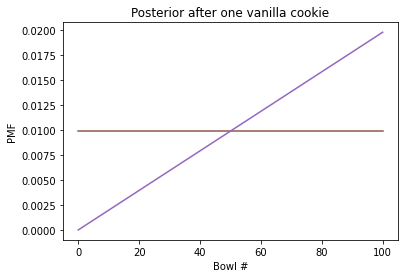

In [34]:
prior.plot(label='prior', color='C5')
posterior1.plot(label='posterior', color='C4')
plt.title('Posterior after one vanilla cookie')
plt.xlabel('Bowl #')
plt.ylabel('PMF')

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie. Here’s the update after the second cookie:

Now suppose we put the cookie back, draw again from the same bowl, and get another vanilla cookie. Here’s the update after the second cookie:

In [37]:
posterior2 = posterior1 * likelihood_vanilla
posterior2.normalize()

0.6699999999999999

Text(0.5, 1.0, 'Posterior after two vanilla cookies')

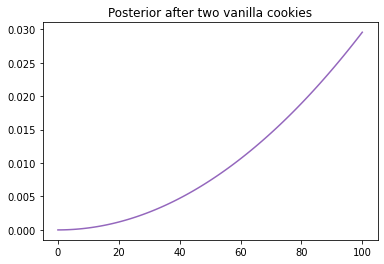

In [38]:
posterior2.plot(label='posterior', color='C4')
plt.title('Posterior after two vanilla cookies')

But suppose we draw again and get a chocolate cookie. Here’s the update:

In [39]:
likelihood_chocolate = 1 - hypos / 100

posterior3 = posterior2 * likelihood_chocolate
posterior3.normalize()

0.2462686567164179

Text(0.5, 1.0, 'Posterior after 2 vanilla, 1 chocolate')

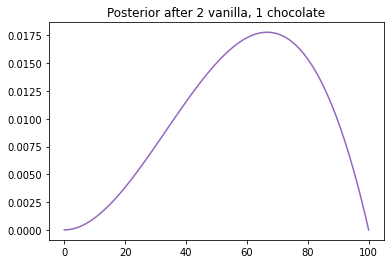

In [40]:
posterior3.plot(label='posterior', color='C4')
plt.title('Posterior after 2 vanilla, 1 chocolate')

Now Bowl 100 has been eliminated because it contains no chocolate cookies.
But the high-numbered bowls are still more likely than the low-numbered bowls, because we have seen more vanilla cookies than chocolate.

In fact, the peak of the posterior distribution is at Bowl 67, which corresponds to the fraction of vanilla cookies in the data we've observed, $2/3$.

The quantity with the highest posterior probability is called the **MAP**, which stands for "maximum a posteori probability", where "a posteori" is unnecessary Latin for "posterior".

To compute the MAP, we can use the `Series` method `idxmax`:

In [41]:
posterior3.idxmax()

67

In [42]:
posterior3.max_prob()

67

As you might suspect, this example isn't really about bowls; it's about estimating proportions.
Imagine that you have one bowl of cookies.
You don't know what fraction of cookies are vanilla, but you think it is equally likely to be any fraction from 0 to 1.
If you draw three cookies and two are vanilla, what proportion of cookies in the bowl do you think are vanilla?

## Estimating Proportions: The Euro Problem

In *Information Theory, Inference, and Learning Algorithms*, David MacKay poses this problem:

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

To answer that question, we'll proceed in two steps.
First we'll use the binomial distribution to see where that 7% came from; then we'll use Bayes's Theorem to estimate the probability that this coin comes up heads.

$$\binom{n}{k} p^k (1-p)^{n-k}$$

In [3]:
n = 2
p = 0.5
k = 1

binom.pmf(k, n, p)

0.5000000000000002

In [4]:
ks = np.arange(n + 1)

ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [5]:
pmf_k = Pmf(ps, ks)
pmf_k

,probs
0,0.25
1,0.50
2,0.25


In [6]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n + 1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

In [7]:
pmf_k = make_binomial(n=250, p=0.5)

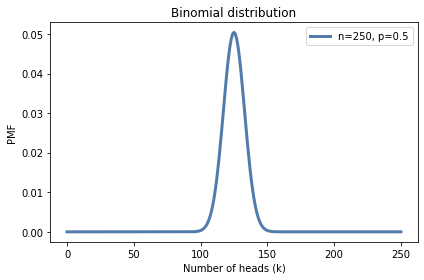

In [8]:
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [9]:
pmf_k.max_prob()

125

In [10]:
pmf_k[125]

0.0504122131473097

In [11]:
pmf_k[140]

0.008357181724918204

In [12]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

In [13]:
prob_ge(pmf_k, 140)

0.03321057562002169

In [14]:
pmf_k.prob_ge(140)

0.03321057562002169

The result is about 3.3%, which is less than the quoted 7%.  The reason for the difference is that the statistician includes all outcomes "as extreme as" 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125.  If we get 140, we've exceeded that expectation by 15.
And if we get 110, we have come up short by 15.

7% is the sum of both of these "tails", as shown in the following figure.

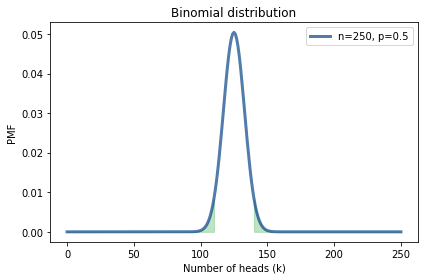

In [22]:
def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C25', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs >= 140])
fill_below(pmf_k[qs <= 110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

In [23]:
pmf_k.prob_le(110)

0.03321057562002169

## Bayesian Estimation

Any given coin has some probability of landing heads up when spun
on edge; I'll call this probability `x`.
It seems reasonable to believe that `x` depends
on physical characteristics of the coin, like the distribution
of weight.
If a coin is perfectly balanced, we expect `x` to be close to 50%, but
for a lopsided coin, `x` might be substantially different.
We can use Bayes's theorem and the observed data to estimate `x`.

For simplicity, I'll start with a uniform prior, which assumes that all values of `x` are equally likely.
That might not be a reasonable assumption, so we'll come back and consider other priors later.

In [24]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

In [27]:
likelihood_heads = hypos
likelihood_tails = 1 - hypos

In [28]:
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

In [29]:
dataset = 'H' * 140 + 'T' * 110

In [30]:
def update_euro(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]

    pmf.normalize()

In [31]:
posterior = prior.copy()
update_euro(posterior, dataset)

In [32]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

In [34]:
posterior.head()

,probs
0.00,0.000000e+00
0.01,1.256330e-207
0.02,5.731921e-166


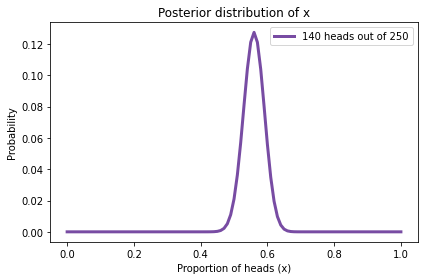

In [33]:
posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

This figure shows the posterior distribution of `x`, which is the proportion of heads for the coin we observed.

The posterior distribution represents our beliefs about `x` after seeing the data.
It indicates that values less than 0.4 and greater than 0.7 are unlikely; values between 0.5 and 0.6 are the most likely.

In fact, the most likely value for `x` is 0.56 which is the proportion of heads in the dataset, `140/250`.

In [35]:
posterior.max_prob()

0.56

## Triangle Prior

In [36]:
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

101

In [38]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)

a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

2500

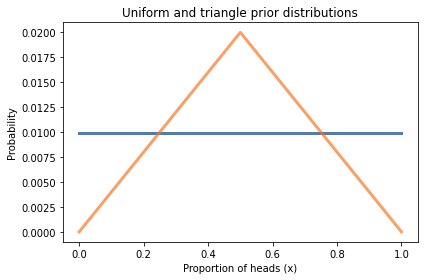

In [39]:
uniform.plot()
triangle.plot()
decorate_euro(title='Uniform and triangle prior distributions')

In [40]:
update_euro(uniform, dataset)
update_euro(triangle, dataset)

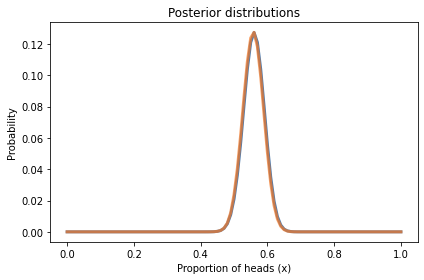

In [41]:
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice.

And that's good news.
To see why, imagine two people who disagree angrily about which prior is better, uniform or triangle.
Each of them has reasons for their preference, but neither of them can persuade the other to change their mind.

But suppose they agree to use the data to update their beliefs.
When they compare their posterior distributions, they find that there is almost nothing left to argue about.

This is an example of **swamping the priors**: with enough
data, people who start with different priors will tend to
converge on the same posterior distribution.

## The Binomial Likelihood Function

So far we've been computing the updates one spin at a time, so for the Euro problem we have to do 250 updates.

A more efficient alternative is to compute the likelihood of the entire dataset at once.
For each hypothetical value of `x`, we have to compute the probability of getting 140 heads out of 250 spins.

Well, we know how to do that; this is the question the binomial distribution answers.
If the probability of heads is $p$, the probability of $k$ heads in $n$ spins is:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

In [42]:
def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [43]:
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

In [44]:
np.allclose(uniform, uniform2)

True

## Estimating Counts

## The Train Problem

I found the train problem 
in Frederick Mosteller's, [*Fifty Challenging Problems in
  Probability with Solutions*](https://store.doverpublications.com/0486653552.html):

> "A railroad numbers its locomotives in order 1..N.  One day you see a locomotive with the number 60.  Estimate how many locomotives the railroad has."

Based on this observation, we know the railroad has 60 or more
locomotives.  But how many more?  To apply Bayesian reasoning, we
can break this problem into two steps:

* What did we know about $N$ before we saw the data?

* For any given value of $N$, what is the likelihood of seeing the data (a locomotive with number 60)?

The answer to the first question is the prior.  The answer to the
second is the likelihood.

We don't have much basis to choose a prior, so we'll start with
something simple and then consider alternatives.
Let's assume that $N$ is equally likely to be any value from 1 to 1000.

In [45]:
hypos = np.arange(1, 1001)
prior = Pmf(1, hypos)

In [46]:
def update_train(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [47]:
data = 60
posterior = prior.copy()
update_train(posterior, data)

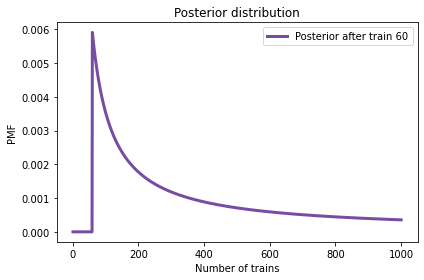

In [48]:
posterior.plot(label='Posterior after train 60', color='C4')
decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distribution')

In [49]:
posterior.max_prob()

60

That might not seem like a very good guess; after all, what are the chances that you just happened to see the train with the highest number?
Nevertheless, if you want to maximize the chance of getting
the answer exactly right, you should guess 60.

But maybe that's not the right goal.
An alternative is to compute the mean of the posterior distribution.
Given a set of possible quantities, $q_i$, and their probabilities, $p_i$, the mean of the distribution is:

$$\mathrm{mean} = \sum_i p_i q_i$$

In [51]:
np.sum(posterior.ps * posterior.qs)

333.41989326370776

In [52]:
posterior.mean()

333.41989326370776

The mean of the posterior is 333, so that might be a good guess if you want to minimize error.
If you played this guessing game over and over, using the mean of the posterior as your estimate would minimize the [mean squared error](http://en.wikipedia.org/wiki/Minimum_mean_square_error) over the long run.

## Sensitivity to the Prior

The prior I used in the previous section is uniform from 1 to 1000, but I offered no justification for choosing a uniform distribution or that particular upper bound.
We might wonder whether the posterior distribution is sensitive to the prior.
With so little data---only one observation---it is.

In [53]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    update_train(pmf, data=60)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,207.079228
1000,333.419893
2000,552.179017


As we vary the upper bound, the posterior mean changes substantially.
So that's bad.  

When the posterior is sensitive to the prior, there are two ways to proceed:

* Get more data.

* Get more background information and choose a better prior.

With more data, posterior distributions based on different priors tend to converge.  
For example, suppose that in addition to train 60 we also see trains 30 and 90.

Here's how the posterior means depend on the upper bound of the prior, when we observe three trains:

In [54]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    pmf = Pmf(1, hypos)
    for data in dataset:
        update_train(pmf, data)
    df.loc[high] = pmf.mean()
    
df

,Posterior mean
Upper bound,
500,151.849588
1000,164.305586
2000,171.338181


The differences are smaller, but apparently three trains are not enough for the posteriors to converge.

## Power Law Prior

If more data are not available, another option is to improve the
priors by gathering more background information.
It is probably not reasonable to assume that a train-operating company with 1000 locomotives is just as likely as a company with only 1.

With some effort, we could probably find a list of companies that
operate locomotives in the area of observation.
Or we could interview an expert in rail shipping to gather information about the typical size of companies.

But even without getting into the specifics of railroad economics, we
can make some educated guesses.
In most fields, there are many small companies, fewer medium-sized companies, and only one or two very large companies.

In fact, the distribution of company sizes tends to follow a power law, as Robert Axtell reports in *Science* (<http://www.sciencemag.org/content/293/5536/1818.full.pdf>).

This law suggests that if there are 1000 companies with fewer than
10 locomotives, there might be 100 companies with 100 locomotives,
10 companies with 1000, and possibly one company with 10,000 locomotives.

Mathematically, a power law means that the number of companies with a given size, $N$, is proportional to $(1/N)^{\alpha}$, where $\alpha$ is a parameter that is often near 1.

In [73]:
alpha = 1.0
ps = hypos ** (-alpha)
power = Pmf(ps, hypos, name='power law')
power.normalize()

7.485470860550345

In [75]:
hypos = np.arange(1, 1001)
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

1000

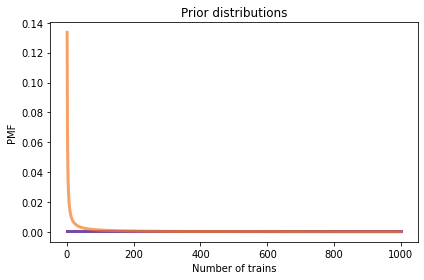

In [76]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Prior distributions')

In [77]:
dataset = [60]
update_train(uniform, dataset)
update_train(power, dataset)

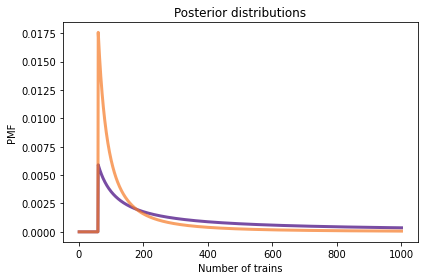

In [78]:
uniform.plot(color='C4')
power.plot(color='C1')

decorate(xlabel='Number of trains',
         ylabel='PMF',
         title='Posterior distributions')

In [79]:
df = pd.DataFrame(columns=['Posterior mean'])
df.index.name = 'Upper bound'

alpha = 1.0
dataset = [30, 60, 90]

for high in [500, 1000, 2000]:
    hypos = np.arange(1, high+1)
    ps = hypos**(-alpha)
    power = Pmf(ps, hypos)
    for data in dataset:
        update_train(power, data)
    df.loc[high] = power.mean()
    
df

,Posterior mean
Upper bound,
500,130.708470
1000,133.275231
2000,133.997463


Now the differences are much smaller.  In fact,
with an arbitrarily large upper bound, the mean converges on 134.

So the power law prior is more realistic, because it is based on
general information about the size of companies, and it behaves better in practice.

## Credible Intervals

So far we have seen two ways to summarize a posterior distribution: the value with the highest posterior probability (the MAP) and the posterior mean.
These are both **point estimates**, that is, single values that estimate the quantity we are interested in.

Another way to summarize a posterior distribution is with percentiles.
If you have taken a standardized test, you might be familiar with percentiles.
For example, if your score is the 90th percentile, that means you did as well as or better than 90\% of the people who took the test.

If we are given a value, `x`, we can compute its **percentile rank** by finding all values less than or equal to `x` and adding up their probabilities.

`Pmf` provides a method that does this computation.
So, for example, we can compute the probability that the company has less than or equal to 100 trains:

In [80]:
power.prob_le(100)

0.2937469222495771

With a power law prior and a dataset of three trains, the result is about 29%. So 100 trains is the 29th percentile.

In [81]:
def quantile(pmf, prob):
    """Compute a quantile with the given prob."""
    total = 0
    for q, p in pmf.items():
        total += p
        if total >= prob:
            return q
    return np.nan

This function is called `quantile` because it computes a quantile rather than a percentile.
The difference is the way we specify `prob`.
If `prob` is a percentage between 0 and 100, we call the corresponding quantity a percentile.
If `prob` is a probability between 0 and 1, we call the corresponding quantity a **quantile**.

In [82]:
quantile(power, 0.5)

113

In [83]:
power.quantile([0.05, 0.95])

array([ 91., 243.])

The result is the interval from 91 to 243 trains, which implies:

* The probability is 5% that the number of trains is less than or equal to 91.

* The probability is 5% that the number of trains is greater than 243.

Therefore the probability is 90% that the number of trains falls between 91 and 243 (excluding 91 and including 243).
For this reason, this interval is called a 90% **credible interval**.

In [84]:
power.credible_interval(0.9)

array([ 91., 243.])

## Odds

In [85]:
def odds(p):
    return p / (1 - p)

For example, if my team has a 75% chance of winning, the odds in their favor are three to one, because the chance of winning is three times the chance of losing.

In [86]:
odds(0.75)

3.0

You can write odds in decimal form, but it is also common to
write them as a ratio of integers.
So "three to one" is sometimes written $3:1$.

When probabilities are low, it is more common to report the
**odds against** rather than the odds in favor.
For example, if my horse has a 10% chance of winning, the odds in favor are $1:9$.

In [87]:
odds(0.1)

0.11111111111111112

But in that case it would be more common I to say that the odds against are $9:1$.

In [88]:
odds(0.9)

9.000000000000002

In [92]:
def prob(o):
    return o / (o + 1)

In [93]:
prob(3/2)

0.6

In [91]:
def prob2(yes, no):
    return yes / (yes + no)

In [94]:
prob2(3, 2)

0.6

## Bayes's Rule

So far we have worked with Bayes's theorem in the "probability form": 

$$P(H|D) = \frac{P(H)~P(D|H)}{P(D)}$$

Writing $\mathrm{odds}(A)$ for odds in favor of $A$, we can express Bayes's Theorem in "odds form":

$$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$$

This is Bayes's Rule, which says that the posterior odds are the prior odds times the likelihood ratio.
Bayes's Rule is convenient for computing a Bayesian update on paper or in your head. For example, let's go back to the cookie problem:

> Suppose there are two bowls of cookies. Bowl 1 contains 30 vanilla cookies and 10 chocolate cookies. Bowl 2 contains 20 of each. Now suppose you choose one of the bowls at random and, without looking, select a cookie at random. The cookie is vanilla. What is the probability that it came from Bowl 1?

The prior probability is 50%, so the prior odds are 1. The likelihood ratio is $\frac{3}{4} / \frac{1}{2}$, or $3/2$. So the posterior odds are $3/2$, which corresponds to probability $3/5$.

In [95]:
prior_odds = 1
likelihood_ratio = (3/4) / (1/2)
post_odds = prior_odds * likelihood_ratio
post_odds

1.5

In [96]:
post_prob = prob(post_odds)
post_prob

0.6

If we draw another cookie and it’s chocolate, we can do another update:

In [97]:
likelihood_ratio = (1/4) / (1/2)
post_odds *= likelihood_ratio
post_odds

0.75

In [98]:
post_prob = prob(post_odds)
post_prob

0.42857142857142855

## Oliver's Blood

I’ll use Bayes’s Rule to solve another problem from MacKay’s
[*Information Theory, Inference, and Learning Algorithms*](https://www.inference.org.uk/mackay/itila/):

> Two people have left traces of their own blood at the scene of a crime. A suspect, Oliver, is tested and found to have type ‘O’ blood. The blood groups of the two traces are found to be of type ‘O’ (a common type in the local population, having frequency 60%) and of type ‘AB’ (a rare type, with frequency 1%). Do these data \[the traces found at the scene\] give evidence in favor of the proposition that Oliver was one of the people \[who left blood at the scene\]?

To answer this question, we need to think about what it means for data
to give evidence in favor of (or against) a hypothesis. Intuitively, we might say that data favor a hypothesis if the hypothesis is more likely in light of the data than it was before.

In the cookie problem, the prior odds are 1, which corresponds to probability 50%. The posterior odds are $3/2$, or probability 60%. So the vanilla cookie is evidence in favor of Bowl 1.

Bayes's Rule provides a way to make this intuition more precise. Again

$$\mathrm{odds}(A|D) = \mathrm{odds}(A)~\frac{P(D|A)}{P(D|B)}$$

Dividing through by $\mathrm{odds}(A)$, we get: 

$$\frac{\mathrm{odds}(A|D)}{\mathrm{odds}(A)} = \frac{P(D|A)}{P(D|B)}$$

The term on the left is the ratio of the posterior and prior odds. The term on the right is the likelihood ratio, also called the **Bayes
factor**.

If the Bayes factor is greater than 1, that means that the data were
more likely under $A$ than under $B$. And that means that the odds are
greater, in light of the data, than they were before.

If the Bayes factor is less than 1, that means the data were less likely under $A$ than under $B$, so the odds in favor of $A$ go down.

Finally, if the Bayes factor is exactly 1, the data are equally likely
under either hypothesis, so the odds do not change.

Let's apply that to the problem at hand. If Oliver is one of the people who left blood at the crime scene, he accounts for the ‘O’ sample; in that case, the probability of the data is the probability that a random member of the population has type ‘AB’ blood, which is 1%.

If Oliver did not leave blood at the scene, we have two samples to
account for. 
If we choose two random people from the population, what is the chance of finding one with type ‘O’ and one with type ‘AB’? 
Well, there are two ways it might happen: 

* The first person might have ‘O’ and the second ‘AB’, 

* Or the first person might have ‘AB’ and the second ‘O’.

The probability of either combination is $(0.6) (0.01)$, which is 0.6%, so the total probability is twice that, or 1.2%.
So the data are a little more likely if Oliver is *not* one of the people who left blood at the scene.

In [99]:
like1 = 0.01
like2 = 2 * 0.6 * 0.01

likelihood_ratio = like1 / like2
likelihood_ratio

0.8333333333333334

In [100]:
post_odds = 1 * like1 / like2
prob(post_odds)

0.45454545454545453

## Addends

As a first example, suppose you roll two dice and add them up. What is the distribution of the sum?

In [102]:
def make_die(sides):
    outcomes = np.arange(1, sides + 1)
    die = Pmf(1 / sides, outcomes)
    return die

In [103]:
die = make_die(6)

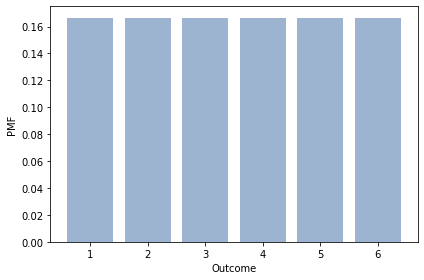

In [104]:
die.bar(alpha=0.4)
decorate(xlabel='Outcome',
         ylabel='PMF')

In [105]:
def add_dist(pmf1, pmf2):
    """Compute the distribution of a sum."""
    res = Pmf()
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            q = q1 + q2
            p = p1 * p2
            res[q] = res(q) + p
    return res

Notice a subtle element of this line:
​
```
            res[q] = res(q) + p
```
​
I use parentheses on the right side of the assignment, which returns 0 if `q` does not appear yet in `res`.
I use brackets on the left side of the assignment to create or update an element in `res`; using parentheses on the left side would not work.

In [106]:
twice = die.add_dist(die)

In [107]:
twice = Pmf.add_dist(die, die)

In [108]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

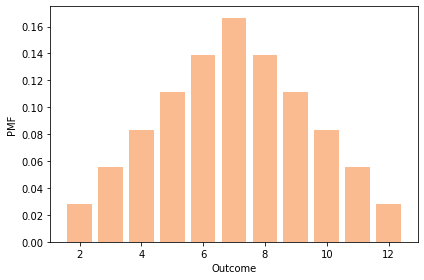

In [109]:
twice.bar(color='C1', alpha=0.5)
decorate_dice()

In [110]:
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [111]:
dice = [die] * 3

In [112]:
thrice = add_dist_seq(dice)

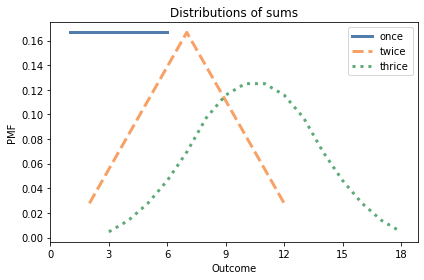

In [113]:
die.plot(label='once')
twice.plot(label='twice', style='--')
thrice.plot(label='thrice', style=':')

plt.xticks([0, 3, 6, 9, 12, 15, 18])
decorate_dice(title='Distributions of sums')

This example demonstrates the **Central Limit Theorem**, which says that the distribution of a sum converges on a bell-shaped normal distribution, at least under some conditions.



## Gluten Sensitivity

In 2015 I read a paper that tested whether people diagnosed with gluten sensitivity (but not celiac disease) were able to distinguish gluten flour from non-gluten flour in a blind challenge
([you can read the paper here](https://onlinelibrary.wiley.com/doi/full/10.1111/apt.13372)).

Out of 35 subjects, 12 correctly identified the gluten flour based on
resumption of symptoms while they were eating it. Another 17 wrongly
identified the gluten-free flour based on their symptoms, and 6 were
unable to distinguish.

The authors conclude, "Double-blind gluten challenge induces symptom
recurrence in just one-third of patients."

This conclusion seems odd to me, because if none of the patients were
sensitive to gluten, we would expect some of them to identify the gluten flour by chance. 
So here's the question: based on this data, how many of the subjects are sensitive to gluten and how many are guessing?

We can use Bayes's Theorem to answer this question, but first we have to make some modeling decisions. I'll assume:

-   People who are sensitive to gluten have a 95% chance of correctly
    identifying gluten flour under the challenge conditions, and

-   People who are not sensitive have a 40% chance of identifying the
    gluten flour by chance (and a 60% chance of either choosing the
    other flour or failing to distinguish).

These particular values are arbitrary, but the results are not sensitive to these choices.

I will solve this problem in two steps. First, assuming that we know how many subjects are sensitive, I will compute the distribution of the data. 
Then, using the likelihood of the data, I will compute the posterior distribution of the number of sensitive patients.

The first is the **forward problem**; the second is the **inverse
problem**.

## The Forward Problem

Suppose we know that 10 of the 35 subjects are sensitive to gluten. That means that 25 are not:

In [115]:
n = 35
num_sensitive = 10
num_insensitive = n - num_sensitive

In [116]:
dist_sensitive = make_binomial(num_sensitive, 0.95)
dist_insensitive = make_binomial(num_insensitive, 0.40)

In [117]:
dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)

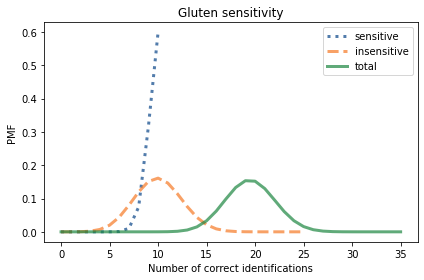

In [119]:
dist_sensitive.plot(label='sensitive', style=':')
dist_insensitive.plot(label='insensitive', style='--')
dist_total.plot(label='total')

decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

We expect most of the sensitive subjects to identify the gluten flour correctly. Of the 25 insensitive subjects, we expect about 10 to identify the gluten flour by chance. So we expect about 20 correct identifications in total.

This is the answer to the forward problem: given the number of sensitive subjects, we can compute the distribution of the data.

## The Inverse Problem

Now let's solve the inverse problem: given the data, we'll compute the posterior distribution of the number of sensitive subjects.

In [121]:
table = pd.DataFrame()
for num_sensitive in range(0, n + 1):
    num_insensitive = n - num_sensitive
    dist_sensitive = make_binomial(num_sensitive, 0.95)
    dist_insensitive = make_binomial(num_insensitive, 0.4)
    dist_total = Pmf.add_dist(dist_sensitive, dist_insensitive)    
    table[num_sensitive] = dist_total

In [122]:
table.head(3)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.719071e-08,1.432559e-09,1.193799e-10,9.948326e-12,8.290272e-13,6.908560e-14,5.757133e-15,4.797611e-16,3.998009e-17,3.331674e-18,...,1.501694e-36,1.251411e-37,1.042843e-38,8.690357e-40,7.241964e-41,6.034970e-42,5.029142e-43,4.190952e-44,3.492460e-45,2.910383e-46
1,4.011165e-07,5.968996e-08,7.162795e-09,7.792856e-10,8.013930e-11,7.944844e-12,7.676178e-13,7.276377e-14,6.796616e-15,6.274653e-16,...,7.508469e-34,6.486483e-35,5.596590e-36,4.823148e-37,4.152060e-38,3.570691e-39,3.067777e-40,2.633315e-41,2.258457e-42,1.935405e-43
2,4.545987e-06,9.741401e-07,1.709122e-07,2.506426e-08,3.269131e-09,3.940182e-10,4.490244e-11,4.908756e-12,5.197412e-13,5.365476e-14,...,1.806613e-31,1.620070e-32,1.449030e-33,1.292922e-34,1.151034e-35,1.022555e-36,9.066202e-38,8.023344e-39,7.088005e-40,6.251357e-41


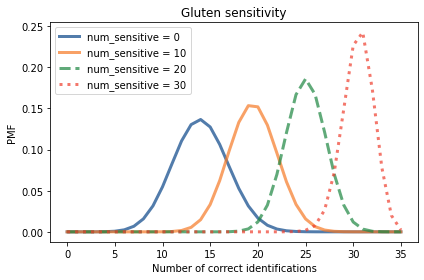

In [123]:
table[0].plot(label='num_sensitive = 0')
table[10].plot(label='num_sensitive = 10')
table[20].plot(label='num_sensitive = 20', style='--')
table[30].plot(label='num_sensitive = 30', style=':')
    
decorate(xlabel='Number of correct identifications',
         ylabel='PMF',
         title='Gluten sensitivity')

In [129]:
likelihood1 = table.loc[12]
likelihood1.shape

(36,)

I’ll use a uniform prior, which implies that I would be equally surprised by any value of `num_sensitive`:

In [130]:
hypos = np.arange(n + 1)
prior = Pmf(1, hypos)
prior.shape

(36,)

In [131]:
posterior1 = prior * likelihood1
posterior1.normalize()

0.47547416486151317

In [132]:
likelihood2 = table.loc[20]
posterior2 = prior * likelihood2
posterior2.normalize()

1.7818649765887378

The following figure shows posterior distributions of `num_sensitive` based on the actual data, 12 correct identifications, and the other possible outcome, 20 correct identifications.

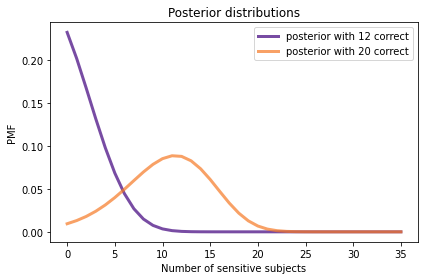

In [133]:
posterior1.plot(label='posterior with 12 correct', color='C4')
posterior2.plot(label='posterior with 20 correct', color='C1')

decorate(xlabel='Number of sensitive subjects',
         ylabel='PMF',
         title='Posterior distributions')

With 12 correct identifications, the most likely conclusion is that none of the subjects are sensitive to gluten. If there had been 20 correct identifications, the most likely conclusion would be that 11-12 of the subjects were sensitive.

In [134]:
posterior1.max_prob()

0

In [135]:
posterior2.max_prob()

11

## Cumulative Distribution Functions¶

In [136]:
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

In [137]:
def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [138]:
update_binomial(pmf, data)

In [139]:
cumulative = pmf.cumsum()

In [140]:
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

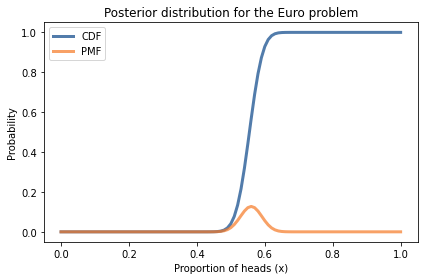

In [141]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')

In [142]:
cumulative[0.61]

0.9638303193984255

In [145]:
ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

In [146]:
cdf = pmf.make_cdf()

In [147]:
cdf[0.61]

0.9638303193984255

In [148]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a Cdf as a function, using parentheses. If the argument does not appear in the Cdf, it interpolates between quantities.

In [149]:
cdf(0.615)

array(0.96383032)

In [150]:
cdf.quantile(0.9638303)

array(0.61)

In [151]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

In [152]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason `Cdf` objects are useful is that they compute quantiles efficiently.
Another is that they make it easy to compute the distribution of a maximum or minimum, as we'll see in the next section.

## Best Three of Four

In *Dungeons & Dragons*, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three.
For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character's strength would be the sum of 2, 3, and 4, which is 9.

As an exercise, let's figure out the distribution of these attributes.
Then, for each character, we'll figure out the distribution of their best attribute.

I'll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of `Pmf` objects and computes the distribution of their sum.

Here's a `Pmf` that represents a six-sided die and a sequence with three references to it.

In [4]:
die = make_die(6)
dice = [die] * 3

In [5]:
pmf_3d6 = add_dist_seq(dice)

In [10]:
def decorate_dice(title=''):
    decorate(xlabel='Outcome',
             ylabel='PMF',
             title=title)

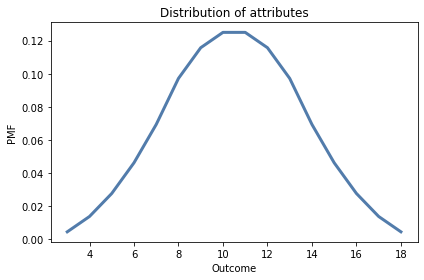

In [7]:
pmf_3d6.plot()
decorate_dice('Distribution of attributes')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated.

In [8]:
n = 10_000
a = np.random.randint(1, 7, size=(n, 4))

In [9]:
a.sort(axis=1)

In [10]:
t = a[:, 1:].sum(axis=1)

In [165]:
t

array([12, 12, 14, ..., 13, 13, 15])

In [11]:
pmf_best3 = Pmf.from_seq(t)

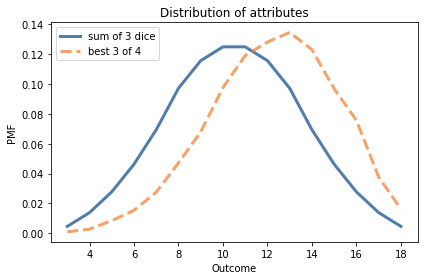

In [12]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', style='--')

decorate_dice('Distribution of attributes')

As you might expect, choosing the best three out of four tends to yield higher values.

## Maximum

We’ll find the distribution for the maximum of six attributes, each the sum of the best three of four dice.


To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function.
First, I'll compute the `Cdf` of the best three of four distribution:

In [13]:
cdf_best3 = pmf_best3.make_cdf()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to `x`.
Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution.
The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

In [14]:
cdf_best3 ** 6

3     1.000000e-18
4     3.010936e-15
5     3.462826e-12
6     4.517297e-10
7     2.859900e-08
8     1.159693e-06
9     2.456667e-05
10    3.721797e-04
11    3.380319e-03
12    1.878787e-02
13    7.562798e-02
14    2.140055e-01
15    4.345241e-01
16    7.167155e-01
17    9.060998e-01
18    1.000000e+00
Name: , dtype: float64

In [16]:
cdf_max6 = Cdf(cdf_best3 ** 6)

In [17]:
pmf_max6 = cdf_max6.make_pmf()

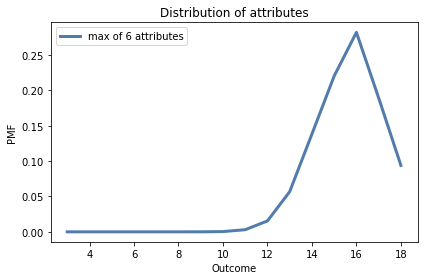

In [18]:
pmf_max6.plot(label='max of 6 attributes')
decorate_dice('Distribution of attributes')

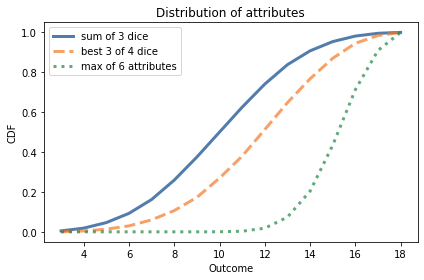

In [176]:
cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', style='--')

cdf_max6.plot(label='max of 6 attributes', style=':')

decorate_dice('Distribution of attributes')
plt.ylabel('CDF');

`Cdf` provides `max_dist`, which does the same computation, so we can also compute the `Cdf` of the maximum like this:

In [177]:
cdf_max_dist6 = cdf_best3.max_dist(6)

In [178]:
np.allclose(cdf_max_dist6, cdf_max6)

True

# Minimum

In [19]:
prob_gt = 1 - cdf_best3

In [20]:
prob_gt6 = prob_gt ** 6

In [21]:
prob_le6 = 1 - prob_gt6

In [22]:
cdf_min6 = Cdf(prob_le6)

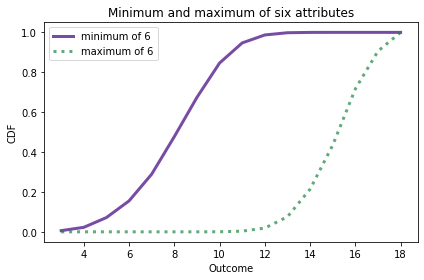

In [23]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', style=':')
decorate_dice('Minimum and maximum of six attributes')
plt.ylabel('CDF');

In [24]:
cdf_min_dist6 = cdf_best3.min_dist(6)

In [25]:
np.allclose(cdf_min_dist6, cdf_min6)

True

## Mixture

In this section I'll show how we can compute a distribution which is a mixture of other distributions.
I'll explain what that means with some simple examples;
then, more usefully, we'll see how these mixtures are used to make predictions.

Here's another example inspired by *Dungeons & Dragons*:

* Suppose your character is armed with a dagger in one hand and a short sword in the other.

* During each round, you attack a monster with one of your two weapons, chosen at random.

* The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

What is the distribution of damage you inflict in each round?

In [4]:
d4 = make_die(4)
d6 = make_die(6)

Now, let’s compute the probability you inflict 1 point of damage.

* If you attacked with the dagger, it’s 1/4.

* If you attacked with the short sword, it’s 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is the average:

In [6]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

For the outcomes 2, 3, and 4, the probability is the same, but for 5 and 6 it’s different, because those outcomes are impossible with the 4-sided die.

In [7]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

In [8]:
mix1 = (d4 + d6) / 2

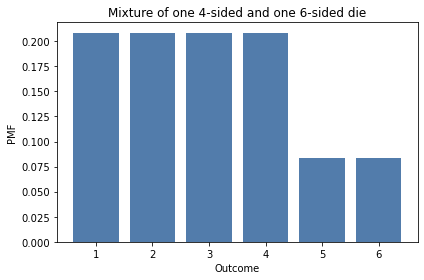

In [11]:
mix1.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and one 6-sided die')

Now suppose you are fighting three monsters:

* One has a club, which causes one 4-sided die of damage.

* One has a mace, which causes one 6-sided die.

* And one has a quarterstaff, which also causes one 6-sided die.

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random. To find the distribution of the damage they inflict, we can compute a weighted average of the distributions, like this:

In [14]:
mix2 = (d4 + 2 * d6) / 3

In [15]:
total_damage = Pmf.add_dist(mix1, mix2)

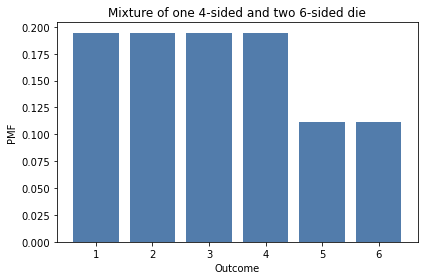

In [16]:
mix2.bar(alpha=0.7)
decorate_dice('Mixture of one 4-sided and two 6-sided die')

In this section we used the `+` operator, which adds the probabilities in the distributions, not to be confused with `Pmf.add_dist`, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I’ll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

In [17]:
total_damage = Pmf.add_dist(mix1, mix2)

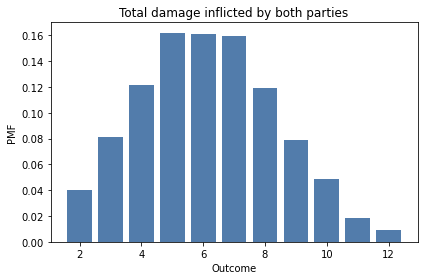

In [18]:
total_damage.bar(alpha=0.7)
decorate_dice('Total damage inflicted by both parties')

## General Mixtures

Suppose three more monsters join the combat, each of them with a battle axe that causes one 8-sided die of damage. Still, only one monster attacks per round, chosen at random, so the damage they inflict is a mixture of:

* One 4-sided die,

* Two 6-sided dice, and

* Three 8-sided dice.

In [19]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


This distribution represents the number of sides on the die we’ll roll and the probability of rolling each one. For example, one of the six monsters has a dagger, so the probability is $1/6$ that we roll a 4-sided die.

In [21]:
dice = [make_die(sides) for sides in hypos]
dice

[1    0.25
 2    0.25
 3    0.25
 4    0.25
 Name: , dtype: float64,
 1    0.166667
 2    0.166667
 3    0.166667
 4    0.166667
 5    0.166667
 6    0.166667
 Name: , dtype: float64,
 1    0.125
 2    0.125
 3    0.125
 4    0.125
 5    0.125
 6    0.125
 7    0.125
 8    0.125
 Name: , dtype: float64]

In [22]:
pd.DataFrame(dice)

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


In [23]:
df = pd.DataFrame(dice).fillna(0).transpose()
df

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


To compute the distribution of the mixture, I’ll compute the weighted average of the dice, using the probabilities in `pmf_dice` as the weights.

In [24]:
df *= pmf_dice.ps

In [25]:
df

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


In [26]:
df.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

In [27]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

The first parameter is a `Pmf` that maps from each hypothesis to a probability. The second parameter is a sequence of `Pmf` objects, one for each hypothesis. We can call it like this:

In [28]:
mix = make_mixture(pmf_dice, dice)

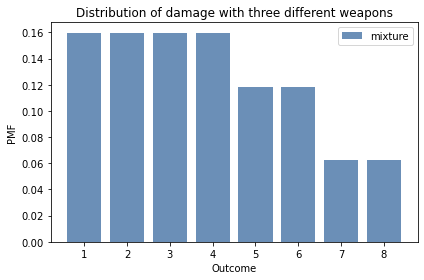

In [29]:
mix.bar(label='mixture', alpha=0.6)
decorate_dice('Distribution of damage with three different weapons')

## Poisson Processes

This chapter introduces the [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process), which is a model used to describe events that occur at random intervals.
As an example of a Poisson process, we'll model goal-scoring in soccer, which is American English for the game everyone else calls "football".
We'll use goals scored in a game to estimate the parameter of a Poisson process; then we'll use the posterior distribution to make predictions.

## The World Cup Problem

In the 2018 FIFA World Cup final, France defeated Croatia 4 goals to 2.  Based on this outcome:

1. How confident should we be that France is the better team?

2. If the same teams played again, what is the chance France would win again?

To answer these questions, we have to make some modeling decisions.

* First, I'll assume that for any team against another team there is some unknown goal-scoring rate, measured in goals per game, which I'll denote with the Python variable `lam` or the Greek letter $\lambda$, pronounced "lambda".

* Second, I'll assume that a goal is equally likely during any minute of a game.  So, in a 90 minute game, the probability of scoring during any minute is $\lambda/90$.

* Third, I'll assume that a team never scores twice during the same minute.

Of course, none of these assumptions is completely true in the real world, but I think they are reasonable simplifications.
As George Box said, "All models are wrong; some are useful."
(https://en.wikipedia.org/wiki/All_models_are_wrong).

In this case, the model is useful because if these assumptions are 
true, at least roughly, the number of goals scored in a game follows a Poisson distribution, at least roughly.

## The Poisson Distribution

If the number of goals scored in a game follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) with a goal-scoring rate, $\lambda$, the probability of scoring $k$ goals is

$$\lambda^k \exp(-\lambda) ~/~ k!$$

for any non-negative value of $k$.

In [31]:
lam = 1.4
dist = poisson(lam)
type(dist)

scipy.stats._distn_infrastructure.rv_frozen

In [32]:
k = 4
dist.pmf(k)

0.039471954028253146

In [33]:
def make_poisson_pmf(lam, qs):
    """Make a Pmf of a Poisson distribution."""
    ps = poisson(lam).pmf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [34]:
lam = 1.4
goals = np.arange(10)
pmf_goals = make_poisson_pmf(lam, goals)

In [35]:
def decorate_goals(title=''):
    decorate(xlabel='Number of goals',
        ylabel='PMF',
        title=title)

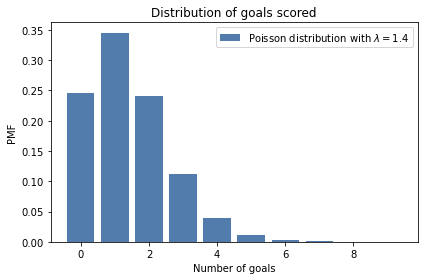

In [36]:
pmf_goals.bar(label=r'Poisson distribution with $\lambda=1.4$')

decorate_goals('Distribution of goals scored')

The most likely outcomes are 0, 1, and 2; higher values are possible but increasingly unlikely. Values above 7 are negligible. This distribution shows that if we know the goal scoring rate, we can predict the number of goals.

Now let’s turn it around: given a number of goals, what can we say about the goal-scoring rate?

To answer that, we need to think about the prior distribution of `lam`, which represents the range of possible values and their probabilities before we see the score.

## The Gamma Distribution

If you have ever seen a soccer game, you have some information about `lam`.  In most games, teams score a few goals each.  In rare cases, a team might score more than 5 goals, but they almost never score more than 10.

Using [data from previous World Cups](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/), I estimate that each team scores about 1.4 goals per game, on average.  So I'll set the mean of `lam` to be 1.4.

For a good team against a bad one, we expect `lam` to be higher; for a bad team against a good one, we expect it to be lower.

To model the distribution of goal-scoring rates, I'll use a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), which I chose because:

1. The goal scoring rate is continuous and non-negative, and the gamma distribution is appropriate for this kind of quantity.

2. The gamma distribution has only one parameter, `alpha`, which is the mean.  So it's easy to construct a gamma distribution with the mean we want.

3. As we'll see, the shape of the gamma distribution is a reasonable choice, given what we know about soccer.

And there's one more reason, which I will reveal in <<_ConjugatePriors>>.

In [39]:
alpha = 1.4
qs = np.linspace(0, 10, 101)
ps = gamma(alpha).pdf(qs)

The parameter, `alpha`, is the mean of the distribution.
The `qs` are possible values of `lam` between 0 and 10.
The `ps` are **probability densities**, which we can think of as unnormalized probabilities.

In [40]:
prior = Pmf(ps, qs)
prior.normalize()

9.889360237140306

In [43]:
def decorate_rate(title=''):
    decorate(xlabel='Goal scoring rate (lam)',
        ylabel='PMF',
        title=title)

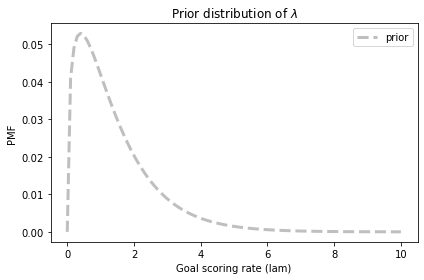

In [44]:
prior.plot(style='--', label='prior', color='C5')
decorate_rate(r'Prior distribution of $\lambda$')

In [46]:
prior.mean()

1.4140818156118378

## The Update

Suppose you are given the goal-scoring rate, $\lambda$, and asked to compute the probability of scoring a number of goals, $k$.  That is precisely the question we answered by computing the Poisson PMF.

For example, if $\lambda$ is 1.4, the probability of scoring 4 goals in a game is:

In [47]:
lam = 1.4
k = 4
poisson(lam).pmf(4)

0.039471954028253146

In [65]:
lams = prior.qs
k = 4
likelihood = poisson(lams).pmf(k)
likelihood

array([0.00000000e+00, 3.77015591e-06, 5.45820502e-05, 2.50026149e-04,
       7.15008049e-04, 1.57950693e-03, 2.96358283e-03, 4.96792214e-03,
       7.66854765e-03, 1.11145981e-02, 1.53283100e-02, 2.03065231e-02,
       2.60231799e-02, 3.24324189e-02, 3.94719540e-02, 4.70665182e-02,
       5.51312092e-02, 6.35746276e-02, 7.23017337e-02, 8.12163834e-02,
       9.02235222e-02, 9.92310359e-02, 1.08151269e-01, 1.16902230e-01,
       1.25408499e-01, 1.33601886e-01, 1.41421844e-01, 1.48815687e-01,
       1.55738624e-01, 1.62153659e-01, 1.68031356e-01, 1.73349519e-01,
       1.78092787e-01, 1.82252178e-01, 1.85824592e-01, 1.88812285e-01,
       1.91222339e-01, 1.93066121e-01, 1.94358757e-01, 1.95118616e-01,
       1.95366815e-01, 1.95126749e-01, 1.94423652e-01, 1.93284180e-01,
       1.91736036e-01, 1.89807621e-01, 1.87527718e-01, 1.84925212e-01,
       1.82028837e-01, 1.78866956e-01, 1.75467370e-01, 1.71857150e-01,
       1.68062503e-01, 1.64108654e-01, 1.60019753e-01, 1.55818804e-01,
      

In [49]:
def update_poisson(pmf, data):
    """Update Pmf with a Poisson likelihood."""
    k = data
    lams = pmf.qs
    likelihood = poisson(lams).pmf(k)
    pmf *= likelihood
    pmf.normalize()

The first parameter is the prior; the second is the number of goals.

In the example, France scored 4 goals, so I’ll make a copy of the prior and update it with the data.

In [50]:
france = prior.copy()
update_poisson(france, 4)

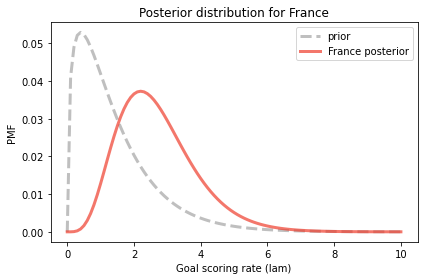

In [51]:
prior.plot(style='--', label='prior', color='C5')
france.plot(label='France posterior', color='C3')

decorate_rate('Posterior distribution for France')

The data, k=4, makes us think higher values of lam are more likely and lower values are less likely. So the posterior distribution is shifted to the right.

Let’s do the same for Croatia:

In [52]:
croatia = prior.copy()
update_poisson(croatia, 2)

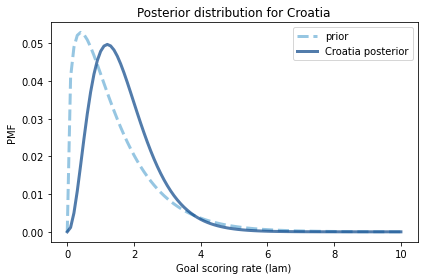

In [53]:
prior.plot(style='--', label='prior', color='C65')
croatia.plot(label='Croatia posterior', color='C0')

decorate_rate('Posterior distribution for Croatia')

In [55]:
print(croatia.mean(), france.mean())

1.6999765866755225 2.699772393342308


The mean of the prior distribution is about 1.4. After Croatia scores 2 goals, their posterior mean is 1.7, which is near the midpoint of the prior and the data. Likewise after France scores 4 goals, their posterior mean is 2.7.

These results are typical of a Bayesian update: the location of the posterior distribution is a compromise between the prior and the data.

## Probability of Superiority

Now that we have a posterior distribution for each team, we can answer the first question: How confident should we be that France is the better team?

In the model, "better" means having a higher goal-scoring rate against the opponent.  We can use the posterior distributions to compute the probability that a random value drawn from France's distribution exceeds a value drawn from Croatia's.

One way to do that is to enumerate all pairs of values from the two distributions, adding up the total probability that one value exceeds the other.

In [58]:
def prob_gt(pmf1, pmf2):
    """Compute the probability of superiority."""
    total = 0
    for q1, p1 in pmf1.items():
        for q2, p2 in pmf2.items():
            if q1 > q2:
                total += p1 * p2
    return total

In [59]:
prob_gt(france, croatia)

0.7499366290930155

In [60]:
Pmf.prob_gt(france, croatia)

0.7499366290930174

The results are slightly different because `Pmf.prob_gt` uses array operators rather than `for` loops.

Either way, the result is close to 75%.  So, on the basis of one game, we have moderate confidence that France is actually the better team.

Of course, we should remember that this result is based on the assumption that the goal-scoring rate is constant.
In reality, if a team is down by one goal, they might play more aggressively toward the end of the game, making them more likely to score, but also more likely to give up an additional goal.

As always, the results are only as good as the model.

## Predicting the Rematch

Now we can take on the second question: If the same teams played again, what is the chance Croatia would win?
To answer this question, we'll generate the "posterior predictive distribution", which is the number of goals we expect a team to score.

If we knew the goal scoring rate, `lam`, the distribution of goals would be a Poisson distribution with parameter `lam`.
Since we don't know `lam`, the distribution of goals is a mixture of a Poisson distributions with different values of `lam`.

First I'll generate a sequence of `Pmf` objects, one for each value of `lam`.

In [61]:
pmf_seq = [make_poisson_pmf(lam, goals) 
           for lam in prior.qs]

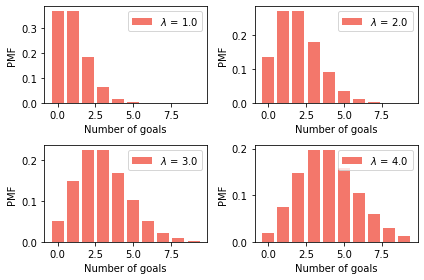

In [64]:
for i, index in enumerate([10, 20, 30, 40]):
    plt.subplot(2, 2, i+1)
    lam = prior.qs[index]
    pmf = pmf_seq[index]
    pmf.bar(label=f'$\lambda$ = {lam}', color='C3')
    decorate_goals()

The predictive distribution is a mixture of these Pmf objects, weighted with the posterior probabilities. 

In [66]:
pred_france = make_mixture(france, pmf_seq)

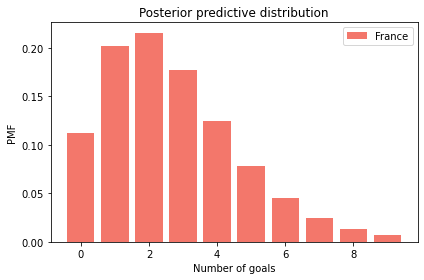

In [67]:
pred_france.bar(color='C3', label='France')
decorate_goals('Posterior predictive distribution')

This distribution represents two sources of uncertainty: we don’t know the actual value of lam, and even if we did, we would not know the number of goals in the next game.

Here’s the predictive distribution for Croatia.

In [72]:
pred_croatia = make_mixture(croatia, pmf_seq)

In [74]:
pred_croatia.qs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

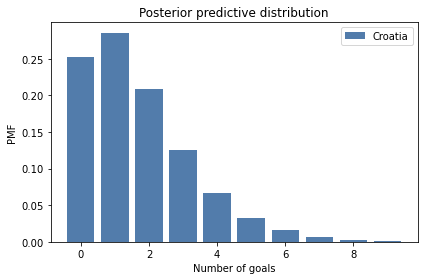

In [70]:
pred_croatia.bar(color='C0', label='Croatia')
decorate_goals('Posterior predictive distribution')

In [77]:
win = Pmf.prob_gt(pred_france, pred_croatia)
win

0.5703522415934519

In [78]:
lose = Pmf.prob_lt(pred_france, pred_croatia)
lose

0.26443376257235873

In [79]:
tie = Pmf.prob_eq(pred_france, pred_croatia)
tie

0.16521399583418947

Assuming that France wins half of the ties, their chance of winning the rematch is about 65%.

In [80]:
win + tie/2

0.6529592395105466

This is a bit lower than their probability of superiority, which is 75%. And that makes sense, because we are less certain about the outcome of a single game than we are about the goal-scoring rates. Even if France is the better team, they might lose the game.

## The Exponential Distribution

As an exercise at the end of this notebook, you'll have a chance to work on  the following variation on the World Cup Problem:

>In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

In this version, notice that the data is not the number of goals in a fixed period of time, but the time between goals.

To compute the likelihood of data like this, we can take advantage of the theory of Poisson processes again.  If each team has a constant goal-scoring rate, we expect the time between goals to follow an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

If the goal-scoring rate is $\lambda$, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$$\lambda \exp(-\lambda t)$$

Because $t$ is a continuous quantity, the value of this expression is not a probability; it is a probability density.  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

SciPy provides `expon`, which creates an object that represents an exponential distribution.
However, it does not take `lam` as a parameter in the way you might expect, which makes it awkward to work with.
Since the PDF of the exponential distribution is so easy to evaluate, I'll use my own function.

In [81]:
def expo_pdf(t, lam):
    """Compute the PDF of the exponential distribution."""
    return lam * np.exp(-lam * t)

In [82]:
lam = 1.4
qs = np.linspace(0, 4, 101)
ps = expo_pdf(qs, lam)
pmf_time = Pmf(ps, qs)
pmf_time.normalize()

25.616650745459093

In [83]:
def decorate_time(title=''):
    decorate(xlabel='Time between goals (games)',
             ylabel='PMF',
             title=title)

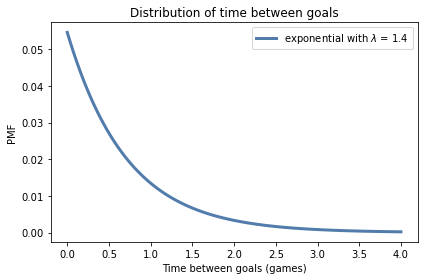

In [84]:
pmf_time.plot(label='exponential with $\lambda$ = 1.4')
decorate_time('Distribution of time between goals')

It is counterintuitive, but true, that the most likely time to score a goal is immediately. After that, the probability of each successive interval is a little lower.

With a goal-scoring rate of 1.4, it is possible that a team will take more than one game to score a goal, but it is unlikely that they will take more than two games.



## Descision Analysis: The Price Is Right Problem

On November 1, 2007, contestants named Letia and Nathaniel appeared on *The Price is Right*, an American television game show. They competed in a game called "The Showcase", where the objective is to guess the price of a collection of prizes. The contestant who comes closest to the actual price, without going over, wins the prizes.

Nathaniel went first. His showcase included a dishwasher, a wine cabinet, a laptop computer, and a car. He bid \\$26,000.

Letia's showcase included a pinball machine, a video arcade game, a pool table, and a cruise of the Bahamas. She bid \\$21,500.

The actual price of Nathaniel's showcase was \\$25,347. His bid was too high, so he lost.

The actual price of Letia's showcase was \\$21,578. 

She was only off by \\$78, so she won her showcase and, because her bid was off by less than 250, she also won Nathaniel's showcase.

For a Bayesian thinker, this scenario suggests several questions:

1. Before seeing the prizes, what prior beliefs should the contestants have about the price of the showcase?

2. After seeing the prizes, how should the contestants update those beliefs?

3. Based on the posterior distribution, what should the contestants bid?

The third question demonstrates a common use of Bayesian methods: decision analysis.

This problem is inspired by [an example](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb) in Cameron Davidson-Pilon's book, [*Probablistic Programming and Bayesian Methods for Hackers*](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).

The Prior
To choose a prior distribution of prices, we can take advantage of data from previous episodes. Fortunately, fans of the show keep detailed records.

For this example, I downloaded files containing the price of each showcase from the 2011 and 2012 seasons and the bids offered by the contestants.

In [93]:
# Load the data files

wget.download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv')
wget.download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv')

100% [................................................................................] 6714 / 6714

'showcases.2012 (1).csv'

In [86]:
def read_data(filename):
    """Read the showcase price data."""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

In [87]:
df2011 = read_data('showcases.2011.csv')
df2012 = read_data('showcases.2012.csv')

df = pd.concat([df2011, df2012], ignore_index=True)

In [88]:
print(df2011.shape, df2012.shape, df.shape)

(191, 6) (122, 6) (313, 6)


In [95]:
df.head(3)

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


## Kernel Density Estimation

This dataset contains the prices for 313 previous showcases, which we can think of as a sample from the population of possible prices.

We can use this sample to estimate the prior distribution of showcase prices.  One way to do that is kernel density estimation (KDE), which uses the sample to estimate a smooth distribution.  If you are not familiar with KDE, you can [read about it here](https://mathisonian.github.io/kde).

SciPy provides `gaussian_kde`, which takes a sample and returns an object that represents the estimated distribution.

The following function takes `sample`, makes a KDE, evaluates it at a given sequence of quantities, `qs`, and returns the result as a normalized PMF.

In [99]:
def kde_from_sample(sample, qs):
    """Make a kernel density estimate from a sample."""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [100]:
qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)

In [101]:
def decorate_value(title=''):
    decorate(xlabel='Showcase value ($)',
        ylabel='PMF',
        title=title)

In [102]:
qs = np.linspace(0, 80000, 81)
prior2 = kde_from_sample(df['Showcase 2'], qs)

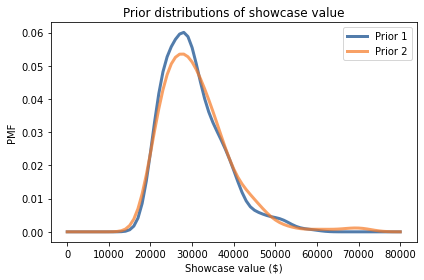

In [103]:
prior1.plot(label='Prior 1')
prior2.plot(label='Prior 2')

decorate_value('Prior distributions of showcase value')

## Distribution of Error

To update these priors, we have to answer these questions:

* What data should we consider and how should we quantify it?

* Can we compute a likelihood function; that is, for each hypothetical price, can we compute the conditional likelihood of the data?

To answer these questions, I will model each contestant as a price-guessing instrument with known error characteristics. 
In this model, when the contestant sees the prizes, they guess the price of each prize and add up the prices.
Let's call this total `guess`.

Now the question we have to answer is, "If the actual price is `price`, what is the likelihood that the contestant's guess would be `guess`?"

Equivalently, if we define `error = guess - price`, we can ask, "What is the likelihood that the contestant's guess is off by `error`?"

To answer this question, I'll use the historical data again. 
For each showcase in the dataset, let's look at the difference between the contestant's bid and the actual price:

In [104]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

In [105]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

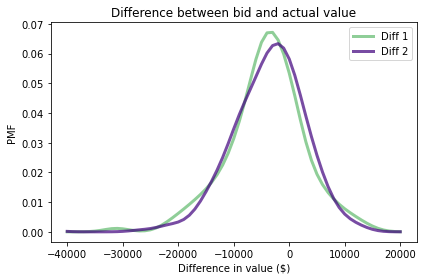

In [106]:
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

It looks like these distributions are well modeled by a normal distribution, so we can summarize them with their mean and standard deviation.

In [107]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377115


Now we can use these differences to model the contestant's distribution of errors.
This step is a little tricky because we don't actually know the contestant's guesses; we only know what they bid.

So we have to make some assumptions:

* I'll assume that contestants underbid because they are being strategic, and that on average their guesses are accurate.  In other words, the mean of their errors is 0.

* But I'll assume that the spread of the differences reflects the actual spread of their errors.  So, I'll use the standard deviation of the differences as the standard deviation of their errors.

Based on these assumptions, I'll make a normal distribution with parameters 0 and `std_diff1`.

In [109]:
error_dist1 = norm(0, std_diff1)

In [110]:
error = -100
error_dist1.pdf(error)

5.7812405640086924e-05

By itself, this number doesn’t mean very much, because probability densities are not probabilities. But they are proportional to probabilities, so we can use them as likelihoods in a Bayesian update, as we’ll see in the next section.

## Update

Suppose you are Player 1. You see the prizes in your showcase and your guess for the total price is \\$23,000.

From your guess I will subtract away each hypothetical price in the prior distribution; the result is your error under each hypothesis.

In [111]:
guess1 = 23000
error1 = guess1 - prior1.qs

Now suppose we know, based on past performance, that your estimation error is well modeled by `error_dist1`. Under that assumption we can compute the likelihood of your error under each hypothesis.

In [112]:
likelihood1 = error_dist1.pdf(error1)

In [113]:
posterior1 = prior1 * likelihood1
posterior1.normalize()

3.3889812097254624e-05

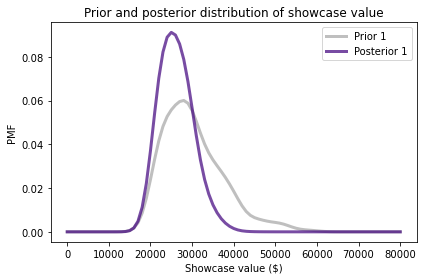

In [114]:
prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')

decorate_value('Prior and posterior distribution of showcase value')

Because your initial guess is in the lower end of the range, the posterior distribution has shifted to the left. We can compute the posterior mean to see by how much.

In [115]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.02400239254)

Before you saw the prizes, you expected to see a showcase with a value close to \$30,000. 

After making a guess of $\$23000$, you updated the prior distribution. Based on the combination of the prior and your guess, you now expect the actual price to be about \$26,000.

**Exercise**: Now suppose you are Player 2. When you see your showcase, you guess that the total price is \$38,000.

Use diff2 to construct a normal distribution that represents the distribution of your estimation errors.

Compute the likelihood of your guess for each actual price and use it to update prior2.

Plot the posterior distribution and compute the posterior mean. Based on the prior and your guess, what do you expect the actual price of the showcase to be?

In [116]:
mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

print(mean_diff2, std_diff2)

-3675.891373801917 6886.26071132341


In [117]:
error_dist2 = norm(0, std_diff2)

In [118]:
guess2 = 38000
error2 = guess2 - prior2.qs

likelihood2 = error_dist2.pdf(error2)

In [119]:
posterior2 = prior2 * likelihood2
posterior2.normalize()

2.6978123219107018e-05

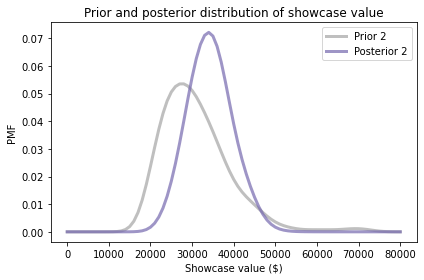

In [120]:
prior2.plot(color='C5', label='Prior 2')
posterior2.plot(color='C15', label='Posterior 2')

decorate_value('Prior and posterior distribution of showcase value')

In [121]:
print(prior2.mean(), posterior2.mean())

31047.623719122505 34305.201616424696


## Probability of Winning
Now that we have a posterior distribution for each player, let’s think about strategy.

First, from the point of view of Player 1, let’s compute the probability that Player 2 overbids. To keep it simple, I’ll use only the performance of past players, ignoring the value of the showcase.

The following function takes a sequence of past bids and returns the fraction that overbid.

In [123]:
def prob_overbid(sample_diff):
    """Compute the probability of an overbid."""
    return np.mean(sample_diff > 0)

In [124]:
prob_overbid(sample_diff2)

0.29073482428115016

Now suppose Player 1 underbids by \$5000. What is the probability that Player 2 underbids by more?

The following function uses past performance to estimate the probability that a player underbids by more than a given amount, diff:

In [125]:
def prob_worse_than(diff, sample_diff):
    """Probability opponent diff is worse than given diff."""
    return np.mean(sample_diff < diff)

In [126]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

In [127]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

In [128]:
def compute_prob_win(diff, sample_diff):
    """Probability of winning for a given diff."""
    # if you overbid you lose
    if diff > 0:
        return 0
    
    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # p1 and p2 are mutually exclusive, so we can add them
    return p1 + p2

In [129]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

In [131]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs]

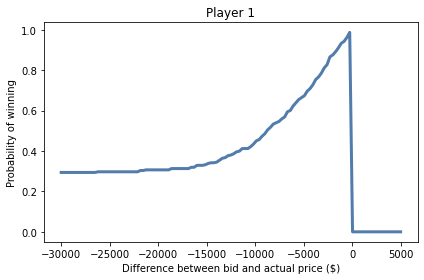

In [133]:
plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 1')

**Exercise**: Run the same analysis from the point of view of Player 2. Using the sample of differences from Player 1, compute:

In [134]:
prob_overbid(sample_diff1)

0.24600638977635783

In [135]:
prob_worse_than(-5000, sample_diff1)

0.3993610223642173

In [136]:
compute_prob_win(-5000, sample_diff1)

0.6453674121405751

In [137]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs]

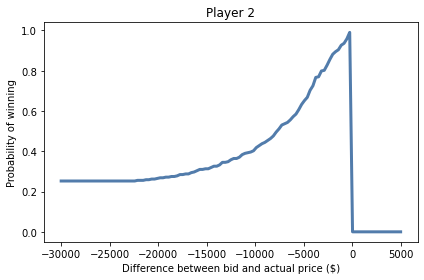

In [138]:
plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 2')

In [140]:
y1 = [compute_prob_win(x, sample_diff2) for x in xs]
y2 = [compute_prob_win(x, sample_diff1) for x in xs]

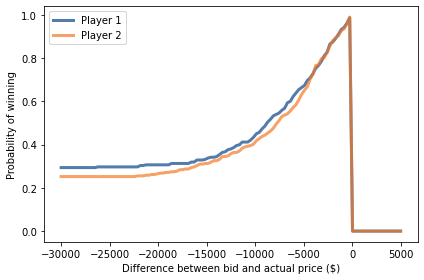

In [143]:
plt.plot(xs, y1, label='Player 1')
plt.plot(xs, y2, label='Player 2')
decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning')

## Decision Analysis

In the previous section we computed the probability of winning, given that we have underbid by a particular amount.

In reality the contestants don't know how much they have underbid by, because they don't know the actual price.

But they do have a posterior distribution that represents their beliefs about the actual price, and they can use that to estimate their probability of winning with a given bid.

The following function takes a possible bid, a posterior distribution of actual prices, and a sample of differences for the opponent.

It loops through the hypothetical prices in the posterior distribution and, for each price,

1. Computes the difference between the bid and the hypothetical price,

2. Computes the probability that the player wins, given that difference, and

3. Adds up the weighted sum of the probabilities, where the weights are the probabilities in the posterior distribution. 

In [144]:
def total_prob_win(bid, posterior, sample_diff):
    """Computes the total probability of winning with a given bid.

    bid: your bid
    posterior: Pmf of showcase value
    sample_diff: sequence of differences for the opponent
    
    returns: probability of winning
    """
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff)
    return total

This loop implements the law of total probability:

$$P(win) = \sum_{price} P(price) ~ P(win ~|~ price)$$

Here's the probability that Player 1 wins, based on a bid of \\$25,000 and the posterior distribution `posterior1`.

In [145]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439813

In [146]:
bids = posterior1.qs
probs = [total_prob_win(bid, posterior1, sample_diff2) for bid in bids]
prob_win_series = pd.Series(probs, index=bids)

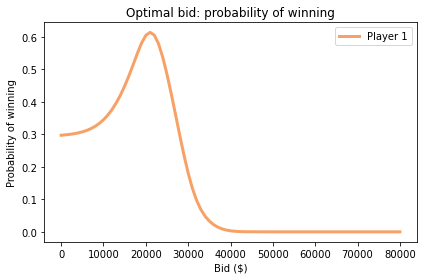

In [147]:
prob_win_series.plot(label='Player 1', color='C1')

decorate(xlabel='Bid ($)',
         ylabel='Probability of winning',
         title='Optimal bid: probability of winning')

In [148]:
prob_win_series.idxmax()

21000.0

In [149]:
prob_win_series.max()

0.6136807192359475

Recall that your guess was \\$23,000. Using your guess to compute the posterior distribution, the posterior mean is about \\$26,000. But the bid that maximizes your chance of winning is \\$21,000.

**Exercise**: Do the same analysis for Player 2.

In [150]:
bids = posterior2.qs
probs = [total_prob_win(bid, posterior2, sample_diff1) for bid in bids]
prob_win_series = pd.Series(probs, index=bids)

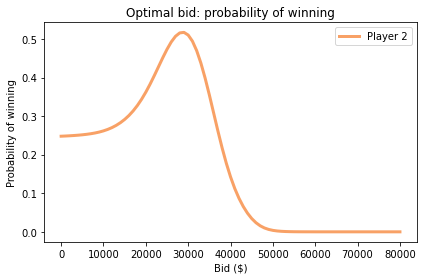

In [151]:
prob_win_series.plot(label='Player 2', color='C1')
decorate(xlabel='Bid ($)',
         ylabel='Probability of winning',
         title='Optimal bid: probability of winning')

In [152]:
prob_win_series.idxmax()

29000.0

In [153]:
prob_win_series.max()

0.5171370053364229

## Maximizing Expected Gain

In the previous section we computed the bid that maximizes your chance of winning. And if that’s your goal, the bid we computed is optimal.

But winning isn’t everything. Remember that if your bid is off by \$250 or less, you win both showcases. So it might be a good idea to increase your bid a little: it increases the chance you overbid and lose, but it also increases the chance of winning both showcases.

Let’s see how that works out. The following function computes how much you will win, on average, given your bid, the actual price, and a sample of errors for your opponent.

In [154]:
def compute_gain(bid, price, sample_diff):
    """Compute expected gain given a bid and actual price."""
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

In [155]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In reality we don’t know the actual price, but we have a posterior distribution that represents what we know about it. By averaging over the prices and probabilities in the posterior distribution, we can compute the expected gain for a particular bid.

In this context, “expected” means the average over the possible showcase values, weighted by their probabilities.

In [156]:
def expected_gain(bid, posterior, sample_diff):
    """Compute the expected gain of a given bid."""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

In [157]:
expected_gain(21000, posterior1, sample_diff2)

16923.59933856512

In [158]:
bids = posterior1.qs
gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]
expected_gain_series = pd.Series(gains, index=bids)

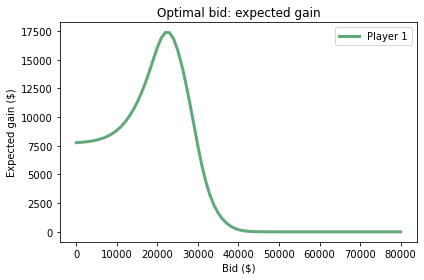

In [159]:
expected_gain_series.plot(label='Player 1', color='C2')

decorate(xlabel='Bid ($)',
         ylabel='Expected gain ($)',
         title='Optimal bid: expected gain')

In [160]:
expected_gain_series.idxmax()

22000.0

In [161]:
expected_gain_series.max()

17384.8995844308

**Exercise**: Do the same analysis for Player 2.

In [162]:
bids = posterior2.qs
gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids]
expected_gain_series = pd.Series(gains, index=bids)

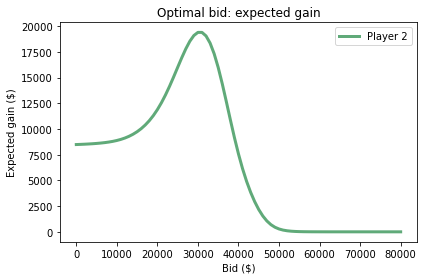

In [163]:
expected_gain_series.plot(label='Player 2', color='C2')

decorate(xlabel='Bid ($)',
    ylabel='Expected gain ($)',
    title='Optimal bid: expected gain')

In [164]:
expected_gain_series.idxmax()

30000.0

In [165]:
expected_gain_series.max()

19404.164188501607

## Discussion

When people discuss the pros and cons of Bayesian estimation, as contrasted with classical methods sometimes called "frequentist", they often claim that in many cases Bayesian methods and frequentist methods produce the same results.

In my opinion, this claim is mistaken because Bayesian and frequentist method produce different *kinds* of results:

* The result of frequentist methods is usually a single value that is considered to be the best estimate (by one of several criteria) or an interval that quantifies the precision of the estimate.

* The result of Bayesian methods is a posterior distribution that represents all possible outcomes and their probabilities.

## Testing

In <<_TheEuroProblem>> I presented a problem from David MacKay's book, [*Information Theory, Inference, and Learning Algorithms*](http://www.inference.org.uk/mackay/itila/p0.html):

"A statistical statement appeared in *The Guardian* on Friday January 4, 2002:

> When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'

"But [MacKay asks] do these data give evidence that the coin is biased rather than fair?"

We started to answer this question in <<_EstimatingProportions>>; to review, our answer was based on these modeling decisions:

* If you spin a coin on edge, there is some probability, $x$, that it will land heads up.

* The value of $x$ varies from one coin to the next, depending on how the coin is balanced and possibly other factors.

Starting with a uniform prior distribution for $x$, we updated it with the given data, 140 heads and 110 tails.  Then we used the posterior distribution to compute the most likely value of $x$, the posterior mean, and a credible interval.

But we never really answered MacKay's question: "Do these data give evidence that the coin is biased rather than fair?"

In this chapter, finally, we will.

## Estimation

Let’s review the solution to the Euro problem from <<_TheBinomialLikelihoodFunction>>. We started with a uniform prior.

In [166]:
xs = np.linspace(0, 1, 101)
uniform = Pmf(1, xs)

In [167]:
k, n = 140, 250
likelihood = binom.pmf(k, n, xs)

In [168]:
posterior = uniform * likelihood
posterior.normalize()

0.3984063745019918

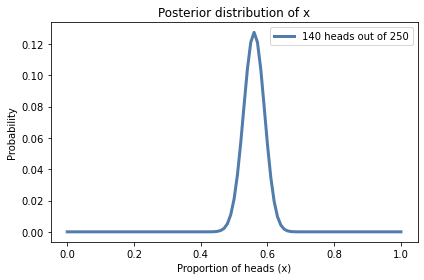

In [169]:
posterior.plot(label='140 heads out of 250')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Posterior distribution of x')

In [170]:
print(posterior.mean(), posterior.credible_interval(0.9))

0.5595238095238094 [0.51 0.61]


The prior mean was 0.5, and the posterior mean is 0.56, so it seems like the data is evidence that the coin is biased.

But, it turns out not to be that simple.

## Evidence

In <<_OliversBlood>>, I said that data are considered evidence in favor of a hypothesis, $A$, if the data are more likely under $A$ than under the alternative, $B$; that is if

$$P(D|A) > P(D|B)$$

Furthermore, we can quantify the strength of the evidence by computing the ratio of these likelihoods, which is known as the [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) and often denoted $K$:

$$K = \frac{P(D|A)}{P(D|B)}$$

So, for the Euro problem, let's consider two hypotheses, `fair` and `biased`, and compute the likelihood of the data under each hypothesis.

If the coin is fair, the probability of heads is 50%, and we can compute the probability of the data (140 heads out of 250 spins) using the binomial distribution:

In [171]:
k = 140
n = 250

like_fair = binom.pmf(k, n, p=0.5)
like_fair

0.008357181724918204

In [172]:
like_biased = binom.pmf(k, n, p=0.56)
like_biased

0.05077815959518339

In [173]:
K = like_biased / like_fair
K

6.075990838368468

The data are about 6 times more likely if the coin is biased, by this definition, than if it is fair.

But we used the data to define the hypothesis, which seems like cheating. To be fair, we should define “biased” before we see the data.

## Uniformly Distributed Bias
Suppose “biased” means that the probability of heads is anything except 50%, and all other values are equally likely.

We can represent that definition by making a uniform distribution and removing 50%.

In [175]:
biased_uniform = uniform.copy()
biased_uniform[0.5] = 0
biased_uniform.normalize()

100

To compute the total probability of the data under this hypothesis, we compute the conditional probability of the data for each value of $x$.

In [176]:
xs = biased_uniform.qs
likelihood = binom.pmf(k, n, xs)

In [177]:
like_uniform = np.sum(biased_uniform * likelihood)
like_uniform

0.003900491927770735

In [178]:
K = like_fair / like_uniform
K

2.1425968518013625

The data are about two times more likely if the coin is fair than if it is biased, by this definition of “biased”.

To get a sense of how strong that evidence is, we can apply Bayes’s rule. For example, if the prior probability is 50% that the coin is biased, the prior odds are 1, so the posterior odds are about 2.1 to 1 and the posterior probability is about 68%.

In [179]:
prior_odds = 1
posterior_odds = prior_odds * K
posterior_odds

2.1425968518013625

In [182]:
def prob(o):
    return o / (o + 1)

In [181]:
posterior_probability = prob(posterior_odds)
posterior_probability

0.6817918278551092

Evidence that “moves the needle” from 50% to 68% is not very strong.

Now suppose “biased” doesn’t mean every value of $x$ is equally likely. Maybe values near 50% are more likely and values near the extremes are less likely. We could use a triangle-shaped distribution to represent this alternative definition of “biased”:

In [183]:
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)

triangle = Pmf(a, xs, name='triangle')
triangle.normalize()

2500

In [184]:
biased_triangle = triangle.copy()
biased_triangle[0.5] = 0
biased_triangle.normalize()

0.98

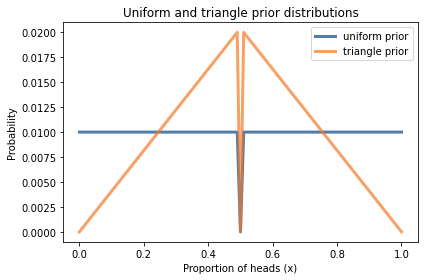

In [185]:
biased_uniform.plot(label='uniform prior')
biased_triangle.plot(label='triangle prior')

decorate(xlabel='Proportion of heads (x)',
         ylabel='Probability',
         title='Uniform and triangle prior distributions')

In [186]:
like_triangle = np.sum(biased_triangle * likelihood)
like_triangle

0.00698132546485788

In [187]:
K = like_fair / like_triangle
K

1.1970766535647157

## The Dice Problem

In the previous chapter we solved the dice problem using a Bayes table.
Here's the statement of the problem:

> Suppose I have a box with a 6-sided die, an 8-sided die, and a 12-sided die.
> I choose one of the dice at random, roll it, and report that the outcome is a 1.
> What is the probability that I chose the 6-sided die?


In [43]:
hypos = [6, 8, 12]

In [44]:
prior = Pmf(1/3, hypos)
prior

,probs
6,0.333333
8,0.333333
12,0.333333


In [45]:
prior.qs

array([ 6,  8, 12])

In [46]:
prior.ps

array([0.33333333, 0.33333333, 0.33333333])

In [47]:
likelihood1 = 1/6, 1/8, 1/12

In [49]:
posterior = prior * likelihood1
posterior.normalize()
posterior

,probs
6,0.444444
8,0.333333
12,0.222222


Now suppose I roll the same die again and get a 7. Here are the likelihoods:

In [50]:
likelihood2 = 0, 1/8, 1/12

In [51]:
posterior *= likelihood2
posterior.normalize()
posterior

,probs
6,0.000000
8,0.692308
12,0.307692


## Updating Dice

In [52]:
def update_dice(pmf, data):
    """Update pmf based on new data."""
    hypos = pmf.qs
    likelihood = 1 / hypos
    impossible = (data > hypos)
    likelihood[impossible] = 0
    pmf *= likelihood
    pmf.normalize()

In [53]:
pmf = prior.copy()
pmf

,probs
6,0.333333
8,0.333333
12,0.333333


In [54]:
update_dice(pmf, 1)
update_dice(pmf, 7)
pmf

,probs
6,0.000000
8,0.692308
12,0.307692
